## <span style="color:green">**Version en cours**</span>

# Segmentez des clients d'un site e-commerce
## Notebook 2 : Feature ingineering
OpenClassrooms - Parcours Data Scientist - Projet 05  

## Présentation du projet

**Contexte**  


* Olist est une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.  
* Dans un premier temps il est demandé de réaliser quelques requêtes pour le dashboard à partir de la base de données SQLite d'Olist.  
* La mission principale est de fournir aux équipes d'e-commerce d'Olist une **segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

**Démarche globale**  
* Requêtes SQL pour le dashboard (cf Notebook 1)  
* **Feature ingineering** : c'est l'objet de ce notebook
* Tests de modèles de clustering (Notebook 3)  
* Simulation d'un contrat de maintenace (Notebbok 4)  

**Feature ingineering**  
* Objectif :
   * Préparer un dataset qui servira de base aux algorithmes de clustering testés à l'étape suivante  
   * Chaque ligne représentera un client, chaque colonne une feature caractérisant les clients
* Préparation des données pour les algorithmes envisagés (KMeans, DBSCAN, Agglomerative Hierarchical Clustering) :
   * Élimination des valeurs manquantes
   * Traitement des valeurs aberrantes
   * Normalisation / standardisation
   * Encodage des variables catégorielles
* Sélection des features pour réaliser une segmentation des clients de type RFM :
   * **R**écence : Nombre de jours écoulés depuis le dernier achat  
   * **F**réquence : Nombre total d'achats effectués par un client sur une période donnée  
   * **M**ontant : Montant total dépensé par un client sur une période donnée  

## Sommaire  
**Préparation de l'environnement**  
* Environnement virtuel
* Import des modules
* Fonctions

**Chargement des données**
* Schéma relationnel   
* Création des dataframes des tables

**Création des features**  
* Feature `Récence`
* Feature `Fréquence`
* Feature `Montant`
* Création du dataframe `df_features`
* Normalisation

**Finalisation du dataset**  
* Aperçu
* Mise en forme
* Enregistrement

# 1 Préparation de l'environnement

## 1.1 Environnement virtuel

In [1]:
# Vérification environnement virtuel
envs = !conda env list
print(f"Environnement virtuel : {[e for e in envs if '*' in e][0].split('*')[1].strip()}")

Environnement virtuel : C:\Users\chrab\anaconda3\envs\opc5


## 1.2 Import des modules

* Installation conditionnelle des librairies

In [2]:
import sys
import subprocess
import pkg_resources

def install_package(package):
    """Installe une librairie en mode silencieux si elle n'est pas encore installée"""
    try:
        pkg_resources.get_distribution(package)
    except pkg_resources.DistributionNotFound:
        print(f"Installation {package}... ", end='')
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"Terminé.")
    else:
        print(f"{package} est déjà installé.")

In [3]:
# Installation des librairies
install_package('pandas')
install_package('numpy')
install_package('matplotlib')
install_package('seaborn')
install_package('scikit-learn')

pandas est déjà installé.
numpy est déjà installé.
matplotlib est déjà installé.
seaborn est déjà installé.
scikit-learn est déjà installé.


* Import des modules

In [4]:
# Import des modules
import os
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## 1.3 Fonctions

In [5]:
# Renvoit le résultat d'une requête SQL
def query_result(query: str, all_rows: bool=True):
    with sqlite3.connect('olist.db') as conn:
        cursor = conn.cursor()
        cursor.execute(query)
        if all_rows:
            result = cursor.fetchall()
        else:
            result = cursor.fetchone()
            if len(result) == 1:
                result = result[0]
    return result

In [6]:
# Renvoit le résultat d'une requête SQL sous forme de dataframe
def f_query_result(query: str):
    """Renvoit un dataframe contenant le résultat de la requête SQL passée en paramètre sous forme d'un string
    Le fichier de la BDD SQLite 'olist.db' doit être présent dans le répertoire courant.
    """
    with sqlite3.connect('olist.db') as conn:
        df = pd.read_sql_query(query, conn)
    return df

In [7]:
def create_dataframe_and_csv_if_not_exist_from_table(tablename: str):
    """Renvoit un dataframe contenant le contenu de la table passée en paramètre sous forme d'un string
    - Si le fichier csv de la table df_{tablename}.csv n'existe pas :
        * Utilisation de la fonction 'f_query_result' pour récupérer le contenu de la table dans un dataframe
        * Enregistrement du fichier csv
    - Si le fichier csv existe, lecture de son contenu dans un dataframe
    """
    filename = f"df_{tablename}.csv"
    if not os.path.exists(filename):
        query = f'SELECT * FROM {tablename};'
        df = f_query_result(query)
        df.drop(columns='index', inplace=True)
        df.to_csv(filename, index=False)
    else:
        df = pd.read_csv(filename)
    return df

In [8]:
# Description des champs d'une table de la BDD SQLite 'olist.db' (à base de requêtes SQL)
def describe_table(table_name: str, fields=None):
    """Examine :
       - les champs compris dans la liste 'fields' de la table 'table_name'
       - ou tous les champs si 'fields' n'est pas renseigné
    Renvoit un dataframe 'df_infos' composé des variables :
       - 'Colonne' : nom des variables de df
       - 'Type' : type de la colonne
       - 'Valeurs uniques' : nombre de valeurs unique de la colonne
       - 'Valeurs manquantes' : nombre de valeurs manquantes de la colonne
       - '% valeurs manquantes' : pourcentage de valeurs manquantes de la colonne
       - 'Doublons' : nombre de valeurs non uniques (doublons) de la colonne
    """
    # Préparation des colonnes du dataframe de descriptions
    df_names, df_types, df_unique_values, df_duplicates, df_missing_values, df_percentage_missing = [], [], [], [], [], []
    
    # Récupération de la liste des champs de la table
    pragma = query_result(f"PRAGMA table_info({table_name});")
    table_fields = [row[1] for row in pragma]

    # Constitution de la liste des champs à décrire
    if fields is None:
        fields = [field for field in table_fields if field != 'index']
    elif isinstance(fields, str):
        fields = [fields]
        
    # Récupération/calculs des informations descriptives
    total_rows = query_result(f"SELECT COUNT(*) FROM {table_name};", False)
    for field_index, field_name in enumerate(table_fields):
        if field_name in fields:
            field_type = pragma[field_index][2]
            unique_values = query_result(f"SELECT COUNT(DISTINCT {field_name}) FROM {table_name};", False)
            non_null_values = query_result(f"SELECT COUNT({field_name}) FROM {table_name};", False)
            duplicates = non_null_values - unique_values
            missing_values = total_rows - non_null_values
            percentage_missing = (missing_values / total_rows) * 100 if total_rows > 0 else 0
            percentage_missing = str(round(percentage_missing, 2)) + ' %'

            df_names.append(field_name)
            df_types.append(field_type)
            df_unique_values.append(unique_values)
            df_duplicates.append(duplicates)
            df_missing_values.append(missing_values)
            df_percentage_missing.append(percentage_missing)

    # Céation du dataframe de description
    df_infos = pd.DataFrame({
        'Colonne': df_names,
        'Type': df_types,
        'Valeurs uniques': df_unique_values,
        'Doublons': df_duplicates,
        'Valeurs manquantes': df_missing_values,
        '% valeurs manquantes': df_percentage_missing
    }).reset_index(drop=True)

    return df_infos

In [9]:
# Description des variables d'un dataframe
def get_dataframe_infos(df):
    """Examine le dataframe (ou la series) 'df' fourni en paramètre et renvoit un dataframe 'df_infos' composé des variables :
       - 'Colonne' : nom des variables de df
       - 'Type' : type de la colonne
       - 'Valeurs uniques' : nombre de valeurs unique de la colonne
       - 'Valeurs manquantes' : nombre de valeurs manquantes de la colonne
       - '% valeurs manquantes' : pourcentage de valeurs manquantes de la colonne
       - 'Doublons' : nombre de valeurs non uniques (doublons) de la colonne
    """
    if isinstance(df, pd.Series):
        df = df.to_frame()
    number_of_rows = df.shape[0]
    col_names = df.columns
    col_types = df.dtypes
    unique_values = df.nunique()
    missing_values = df.isnull().sum()
    non_missing_values = number_of_rows - missing_values
    duplicate_values = non_missing_values - unique_values

    df_infos = pd.DataFrame({
        'Colonne': col_names,
        'Type': col_types,
        'Valeurs uniques': unique_values,
        'Doublons': duplicate_values,
        'Valeurs manquantes': missing_values,
        '% valeurs manquantes': round((missing_values / number_of_rows) * 100, 2).astype(str) + " %"
    }).reset_index(drop=True)

    return df_infos

In [10]:
# Transforme les types des variables d'un dataframe
def transform_data_types(df, transformations):
    # Conversion en type string ou category si le nbre de valeurs uniques est faible
    if 'to_string' in transformations:
        for column in transformations['to_string']:
            if df[column].nunique() / len(df[column]) < 0.02:
                df[column] = df[column].astype('category')
            else:
                df[column] = df[column].astype(str)
            df[column] = df[column].replace('None', np.nan)
    
    # Conversion en dates avec gestion NaT
    if 'to_date' in transformations:
        if len(df[transformations['to_date']].iloc[0]) <= 10 :
            for column in transformations['to_date']:
                df[column] = pd.to_datetime(df[column], errors='coerce')
        else:
            for column in transformations['to_date']:
                df[column] = pd.to_datetime(df[column], errors='coerce').dt.round('s')
   
    # Conversion en entier avec gestion NaN
    if 'to_integer' in transformations:
        for col in transformations['to_integer']:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

    # Conversion en flottants
    if 'to_float' in transformations:
        for col in transformations['to_float']:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)
    
    return df

In [11]:
# Affiche l'histogramme et le boxplot d'une feature
def plot_distribution(dataframe, feature, x_label, y_label, x_tick_angle=None):
    fig, axs = plt.subplots(2, 1, figsize=(6, 4.5), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    plt.subplots_adjust(hspace=0.05)  # Ajuste l'espace entre les graphiques
    
    # Histogramme
    sns.histplot(dataframe[feature], bins=50, kde=True, ax=axs[0])
    axs[0].set_title(f'Distribution {feature}', pad=10)
    axs[0].set_xlabel('')  # Supprime le label de l'axe x pour l'histogramme
    axs[0].set_ylabel(y_label)
    axs[0].grid(linewidth=0.25)
    
    # Boxplot
    sns.boxplot(x=dataframe[feature], ax=axs[1])
    axs[1].set_xlabel(x_label)
    axs[1].set_yticks([])  # Supprime les ticks de l'axe y pour le boxplot

    if x_tick_angle is not None:
        for axis in axs:
            for label in axis.get_xticklabels():
                label.set_rotation(x_tick_angle)

    plt.show()

# 2 Chargement des données

## 2.1 Schéma relationnel

La réalisation des quelques requêtes pour le dashboard (Notebook 1) a été l'occasion d'étudier les relations entre les tables de la BDD Olist et d'établir le schema relationnel :

![shema relationnel](schema_relationnel_olist.png "Shéma relationnel BDD olist")

## 2.2 Création des dataframes des tables

* Chargement des fichiers csv dans le dataframe correspondant  
* Si le fichier csv n'existe pas, il est créé après avoir lu le contenu de la table dans la BDD

In [12]:
df_customers = create_dataframe_and_csv_if_not_exist_from_table('customers')
df_orders = create_dataframe_and_csv_if_not_exist_from_table('orders')
df_order_pymts = create_dataframe_and_csv_if_not_exist_from_table('order_pymts')
df_order_items = create_dataframe_and_csv_if_not_exist_from_table('order_items')
df_order_reviews = create_dataframe_and_csv_if_not_exist_from_table('order_reviews')
# df_geoloc = create_dataframe_and_csv_if_not_exist_from_table('geoloc')
# df_products = create_dataframe_and_csv_if_not_exist_from_table('products')
# df_sellers = create_dataframe_and_csv_if_not_exist_from_table('sellers')
# df_translation = create_dataframe_and_csv_if_not_exist_from_table('translation')

# 3 Création des features

## 3.1 Préparation du dataframe pour les modèles

* Seuls les clients ayant validé une commande (même si celle-ci n'est pas encore payée ni livrée) seront pris en compte
* Le dataframe devra comprendre une ligne par client  
* Le champ `customer_unique_id` de la table `customers` identifie les clients de manière unique

* Affichage des informations de la table `customers` :

In [13]:
# Version table SQLite
display(describe_table('customers'))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,customer_id,TEXT,99441,0,0,0.0 %
1,customer_unique_id,TEXT,96096,3345,0,0.0 %
2,customer_zip_code_prefix,BIGINT,14994,84447,0,0.0 %
3,customer_city,TEXT,4119,95322,0,0.0 %
4,customer_state,TEXT,27,99414,0,0.0 %


In [14]:
# Version dataframe pandas
display(get_dataframe_infos(df_customers))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,customer_id,object,99441,0,0,0.0 %
1,customer_unique_id,object,96096,3345,0,0.0 %
2,customer_zip_code_prefix,int64,14994,84447,0,0.0 %
3,customer_city,object,4119,95322,0,0.0 %
4,customer_state,object,27,99414,0,0.0 %


* Affichage de quelques lignes

In [15]:
display(df_orders)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


* Il n'y a pas de données manquantes 
* Création du dataframe avec les valeurs uniques de `customer_unique_id`

In [16]:
# Y-a-t-il des 'customer_unique_id' avec des commandes non validées ?
query = """SELECT customer_unique_id, COUNT(o.order_id) AS nombre_de_commandes_non_validees
FROM customers c
LEFT JOIN orders o
ON o.customer_id = c.customer_id
WHERE order_purchase_timestamp IS NULL
GROUP BY customer_unique_id
ORDER BY nombre_de_commandes_non_validees;
"""
result = f_query_result(query)
display(result)

,customer_unique_id,nombre_de_commandes_non_validees


* Visiblement, aucun client n'est enregistré s'il n'a pas validé sa commande
* Utilisation du champ `customer_unique_id` de la table `customers` comme première colonne du dataframe `df_features`

In [17]:
# Création du dataframe 'df_features'
df_features = pd.DataFrame({'customer_id': df_customers['customer_unique_id'].unique()})

* Affichage de quelques lignes

In [18]:
display(df_features)

,customer_id
0,861eff4711a542e4b93843c6dd7febb0
1,290c77bc529b7ac935b93aa66c333dc3
2,060e732b5b29e8181a18229c7b0b2b5e
3,259dac757896d24d7702b9acbbff3f3c
4,345ecd01c38d18a9036ed96c73b8d066
...,...
96091,1a29b476fee25c95fbafc67c5ac95cf8
96092,d52a67c98be1cf6a5c84435bd38d095d
96093,e9f50caf99f032f0bf3c55141f019d99
96094,73c2643a0a458b49f58cea58833b192e


## 3.2 Feature `Récence`

* **Récence** : nombre de jours écoulés depuis le dernier achat  
* La date de référence sera celle du dernier achat (`orders.order_purchase_timestamp`)  
* Une rapide analyse exploratoire de la table `orders` sera réalisée au préalable

### 3.2.1 Analyse de la table `orders`

* Affichage des informations de la table `orders` :

In [19]:
# Version table SQLite
display(describe_table('orders'))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,TEXT,99441,0,0,0.0 %
1,customer_id,TEXT,99441,0,0,0.0 %
2,order_status,TEXT,8,99433,0,0.0 %
3,order_purchase_timestamp,TEXT,98875,566,0,0.0 %
4,order_approved_at,TEXT,90733,8548,160,0.16 %
5,order_delivered_carrier_date,TEXT,81018,16640,1783,1.79 %
6,order_delivered_customer_date,TEXT,95664,812,2965,2.98 %
7,order_estimated_delivery_date,TEXT,459,98982,0,0.0 %


In [20]:
# Version dataframe pandas
display(get_dataframe_infos(df_orders))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,99441,0,0,0.0 %
1,customer_id,object,99441,0,0,0.0 %
2,order_status,object,8,99433,0,0.0 %
3,order_purchase_timestamp,object,98875,566,0,0.0 %
4,order_approved_at,object,90733,8548,160,0.16 %
5,order_delivered_carrier_date,object,81018,16640,1783,1.79 %
6,order_delivered_customer_date,object,95664,812,2965,2.98 %
7,order_estimated_delivery_date,object,459,98982,0,0.0 %


* Affichage de quelques lignes

In [21]:
display(df_orders)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


* Les variables `order_purchase_timestamp`, `order_approved_at`, `order_delivered_carrier_date`, `order_delivered_customer_date`, `order_estimated_delivery_date` doivent être transformées en type `date`  
* La variable `order_status` pourra être transformée en type `string`, car la fonction `tansform_data_type()` est prévue pour convertir automatiquement en type `category` lorsque le nombre de modalités est faible  
* A noter **160** valeurs manquantes pour la variable `order_approved_at`

* Conversions de type

In [22]:
# Dictionnaire de conversion
to_transform = {
    'to_string': ['order_id', 'customer_id', 'order_status'],
    'to_date': ['order_purchase_timestamp',
                'order_approved_at',
                'order_delivered_carrier_date',
                'order_delivered_customer_date',
                'order_estimated_delivery_date']
}

# Conversions
df_orders = transform_data_types(df_orders, to_transform)

* Vérification des conversions

In [23]:
display(get_dataframe_infos(df_orders))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,99441,0,0,0.0 %
1,customer_id,object,99441,0,0,0.0 %
2,order_status,category,8,99433,0,0.0 %
3,order_purchase_timestamp,datetime64[ns],98875,566,0,0.0 %
4,order_approved_at,datetime64[ns],90733,8548,160,0.16 %
5,order_delivered_carrier_date,datetime64[ns],81018,16640,1783,1.79 %
6,order_delivered_customer_date,datetime64[ns],95664,812,2965,2.98 %
7,order_estimated_delivery_date,datetime64[ns],459,98982,0,0.0 %


* Distribution et valeurs aberrantes de la variable `order_purchase_timestamp`

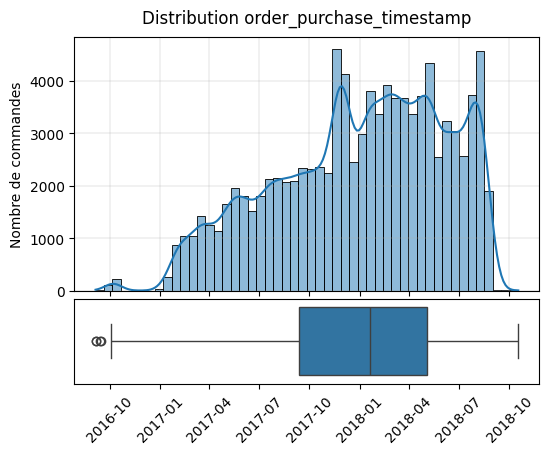

In [24]:
# Affichage histogramme et boxplot
plot_distribution(df_orders, 'order_purchase_timestamp', x_label='', y_label='Nombre de commandes', x_tick_angle=45)

* Valeurs aberrantes
   * Certaines commandes ont été passées **avant janvier 2017**, or il est précisé :
      > *"Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique des commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients **depuis janvier 2017**."*  
   * Il n'y a pas de valeurs aberrantes en fin de période, dans le sens ou il n'y a pas de dates d'achat après le 3ème quatile + 1.5 x l'IQR, mais on constate **une chute du nombre de commandes**.  

* Les commandes passées avant le 1er janvier 2017 devront être exclues
* Quelle que soit la raison de la chute du nombre de commandes en fin de période, il sera préférable d'exclure les données de cette période

### 3.2.3 Recherche du dernier mois bien renseigné

* Répartition mensuelles des commandes 

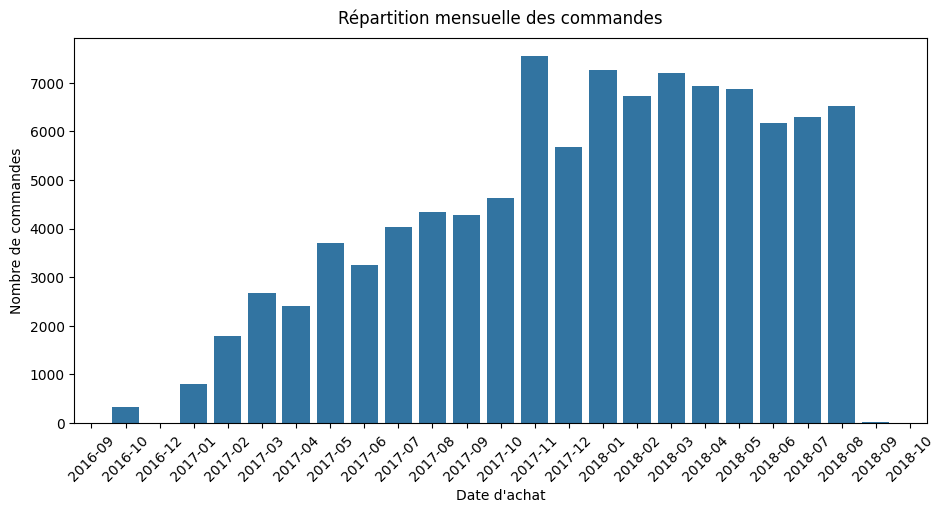

In [25]:
# Ajout de la colonne 'year_month'
df_orders['year_month'] = df_orders['order_purchase_timestamp'].dt.to_period('M')

# Nombre de commandes passées pour chaque valeur de 'year_month'
df_orders_by_year_month = df_orders.groupby('year_month')['order_id'].count().reset_index()

# Affichage barplot
plt.figure(figsize=(11, 5))
sns.barplot(data=df_orders_by_year_month, x='year_month', y='order_id')
plt.xticks(rotation=45)
plt.xlabel('Date d\'achat')
plt.ylabel('Nombre de commandes')
plt.title('Répartition mensuelle des commandes', pad=10)
plt.show()

* On constate un fort décrochage à partir du mois de septembre 2018

### 3.2.2 Exclusion des commandes antérieures à janvier 2017 ou postérieures à août 2018

**Démarche**  
*Les lignes correspondantes aux commandes datées d'avant janvier 2017 ou d'après août 2018 seront supprimées des dataframes*  
* Récupération des `order_id` des commandes passées avant janvier 2017 ou après août 2018  
* Suppression des reviews dans le dataframe `df_reviews`  
* Suppression des réglements dans le dataframe `df_pymts`
* Suppression des produits dans le dataframe `df_order_items`
* Suppression des clients dans le dataframe `df_customers`  
* Suppression des commandes dans le dataframe `df_orders`  
* Reconstitution du dataframe `df_features`

#### 3.2.2.1 Récupération des `order_id` des commandes passées avant le 1er janvier 2017 ou après le 31 août 2018

In [26]:
exclusion_period_mask = (df_orders['order_purchase_timestamp'] < '2017-01-01') | (df_orders['order_purchase_timestamp'] > '2018-08-31')
order_ids_to_exclude = df_orders.loc[exclusion_period_mask, 'order_id']

In [27]:
print(f"{order_ids_to_exclude.shape[0]} commandes ont été passées avant janvier 2017 ou après août 2018")

350 commandes ont été passées avant janvier 2017 ou après août 2018


#### 3.2.2.2 Suppression des reviews dans le dataframe `df_order_reviews`

In [28]:
# Nombre de reviews avant
number_of_reviews = df_order_reviews.shape[0]

# Suppression
df_order_reviews = df_order_reviews[~df_order_reviews['order_id'].isin(order_ids_to_exclude)]

# Résultat
print(f"{number_of_reviews - df_order_reviews.shape[0]} reviews ont été supprimées.")

346 reviews ont été supprimées.


#### 3.2.2.3 Suppression des réglements dans le dataframe `df_order_pymts`

In [29]:
# Nombre de réglements avant
number_of_payments = df_order_pymts.shape[0]

# Suppression
df_order_pymts = df_order_pymts[~df_order_pymts['order_id'].isin(order_ids_to_exclude)]

# Résultat
print(f"{number_of_payments - df_order_pymts.shape[0]} réglements ont été supprimés.")

367 réglements ont été supprimés.


#### 3.2.2.4 Suppression des unités de produits achetés dans le dataframe `df_order_items`

In [30]:
# Nombre d'unités de produits avant
number_of_order_items = df_order_items.shape[0]

# Suppression
df_order_items = df_order_items[~df_order_items['order_id'].isin(order_ids_to_exclude)]

# Résultat
print(f"{number_of_order_items - df_order_items.shape[0]} unités de produits achetés ont été supprimées.")

371 unités de produits achetés ont été supprimées.


#### 3.2.2.5 Suppression des clients dans le dataframe `df_customers`

In [31]:
# Récupération des 'customer_id'
customer_ids_to_exclude = df_orders.loc[exclusion_period_mask, 'customer_id']

In [32]:
# Nombre clients avant
number_of_customers = df_customers['customer_unique_id'].nunique()

# Suppression
df_customers = df_customers[~df_customers['customer_id'].isin(customer_ids_to_exclude)]

# Résultat
print(f"{number_of_customers - df_customers['customer_unique_id'].nunique()} clients ont été supprimées.")

323 clients ont été supprimées.


#### 3.2.2.6 Suppression des commandes dans le dataframe `orders`

In [33]:
# Nombre de commandes avant
number_of_orders = df_orders.shape[0]

# Suppression
df_orders = df_orders.loc[~exclusion_period_mask]

# Résultat
print(f"{number_of_orders - df_orders.shape[0]} commandes ont été supprimées.")

350 commandes ont été supprimées.


#### 3.2.2.6 Reconstitution du dataframe `df_features`

In [34]:
df_features = pd.DataFrame({'customer_unique_id': df_customers['customer_unique_id'].unique()})

In [35]:
display(df_features)

,customer_unique_id
0,861eff4711a542e4b93843c6dd7febb0
1,290c77bc529b7ac935b93aa66c333dc3
2,060e732b5b29e8181a18229c7b0b2b5e
3,259dac757896d24d7702b9acbbff3f3c
4,345ecd01c38d18a9036ed96c73b8d066
...,...
95768,1a29b476fee25c95fbafc67c5ac95cf8
95769,d52a67c98be1cf6a5c84435bd38d095d
95770,e9f50caf99f032f0bf3c55141f019d99
95771,73c2643a0a458b49f58cea58833b192e


* La base de données comptabilise **95 773 clients** ayant passé au moins une commande entre janvier 2017 et août 2018.

### 3.2.4 Calcul de la feature `Récence`

In [36]:
# Merge des features 'customer_unique_id' et 'order_purchase_timestamp' 
df_purchase_timestamp = pd.merge(df_orders[['customer_id', 'order_purchase_timestamp']], df_customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

In [37]:
# Récupération de la date de dernier achat de chaque 'customer_unique_id'
last_purchase_dates = df_purchase_timestamp.groupby(['customer_unique_id']).agg(
    last_purchase_timestamp = ('order_purchase_timestamp', 'max')
).reset_index()

In [38]:
# Conversion de la date de référence au format datetime "YYYY-MM-DD 00:00:00"
last_order_date = pd.to_datetime('2018-08-31')

# Conversion de la date de dernier achat au format datetime "YYYY-MM-DD 00:00:00"
last_purchase_dates['last_purchase_timestamp'] = last_purchase_dates['last_purchase_timestamp'].dt.normalize()

In [39]:
# Calcul de la feature 'Récence'
last_purchase_dates['Récence'] = (last_order_date - last_purchase_dates['last_purchase_timestamp']).dt.days

In [40]:
# Ajout de la feature 'Récence' au dataframe 'df_features'
df_features = pd.merge(df_features, last_purchase_dates[['customer_unique_id', 'Récence']], on='customer_unique_id')

In [41]:
# Affichage de quelques exemples
display(df_features.sort_values('Récence'))

,customer_unique_id,Récence
22899,3158fc4f60ca92412de397461b64cee3,1
52025,230a1e9f42924d41f37fd22a1d4a9707,1
3471,91544d22848a922381b73b5e21ad58ff,1
30363,eb240714223915add224beff2d844e53,1
47451,0c6d7218d5f3fa14514fd29865269993,2
...,...,...
41083,ef89f6e31311594d74becf9e18c73693,603
14564,da9c90677b1963eca1cf8a14c338cf6e,603
41988,29a63a400c3ca9982907ce8de1f19527,603
18388,d753459418d268407f19b64be28e3c5a,603


## 3.3 Feature `Fréquence`

* **Fréquence** : nombre total d'achats effectués par un client sur une période donnée  
* La période choisie doit refléter le cycle d'achat des clients et permettre de distinguer les clients réguliers des clients occasionnels  

### 3.3.1 Détermination de la période

* Répartition mensuelles de commandes

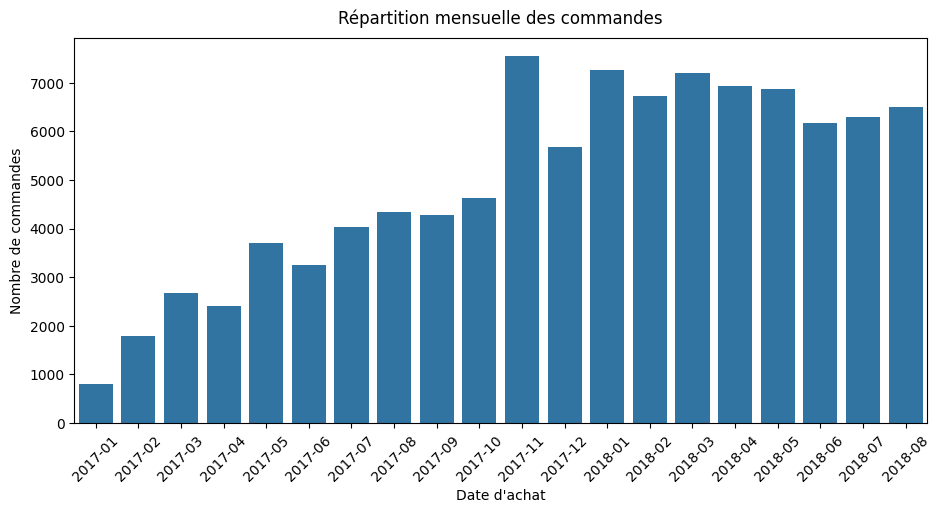

In [42]:
# Nombre de commandes passées pour chaque valeur de 'year_month'
df_orders_by_year_month = df_orders.groupby('year_month')['order_id'].count().reset_index()

# Affichage barplot
plt.figure(figsize=(11, 5))
sns.barplot(data=df_orders_by_year_month, x='year_month', y='order_id')
plt.xticks(rotation=45)
plt.xlabel('Date d\'achat')
plt.ylabel('Nombre de commandes')
plt.title('Répartition mensuelle des commandes', pad=10)
plt.show()

* Nombre de commandes par clients

In [43]:
# Nombre de commandes par 'customer_unique_id'
# Dans les tables 'orders' et 'customers', le champ 'customer_id' représente une commande
number_of_orders_by_customer = df_customers.groupby('customer_unique_id')['customer_id'].count().reset_index()

# Nombre de clients pour chaque "Nombre de commandes"
number_of_customers_by_number_of_orders = number_of_orders_by_customer.groupby('customer_id')['customer_unique_id'].count().reset_index()

# Changement de noms aux colonnes pour plus de clarté
number_of_customers_by_number_of_orders = number_of_customers_by_number_of_orders.rename(columns={'customer_id': 'Nombre de commandes', 'customer_unique_id': 'Nombre de clients'})

# Calcul du pourcentage de clients
number_of_customers = df_features.shape[0]
number_of_customers_by_number_of_orders['% de clients'] = round((number_of_customers_by_number_of_orders['Nombre de clients'] / number_of_customers) * 100, 3)

# Affichage dans l'ordre logique des colonnes
number_of_customers_by_number_of_orders[['Nombre de clients', '% de clients', 'Nombre de commandes']]

,Nombre de clients,% de clients,Nombre de commandes
0,92798,96.894,1
1,2728,2.848,2
2,198,0.207,3
3,30,0.031,4
4,8,0.008,5
5,6,0.006,6
6,3,0.003,7
7,1,0.001,9
8,1,0.001,17


* Les commandes sont en augmentation jusqu'en novembre 2017, puis en relative stagnation
* La période disponible est relativement courte : un peu plus d'un an et demi
* La plupart des clients n'ont fait qu'un seul achat sur cette période  

* Compte-tenu de ces éléments, je choisi de calculer la feature `Fréquence` sur l'intégralité de la période disponible

### 3.3.2 Calcul de la feature `Fréquence`

* Étant donné que seulement un peu plus de **3 %** des clients n'ont passé qu'une seule commande sur la période, je choisi de binariser la feature `Fréquence` :
   * Un score de **0** sera attribué aux clients n'ayant effectué qu'**une commande**  
   * Un score de **1** sera attribué aux clents ayant passé **2 commandes ou plus**

In [44]:
# Fusion des dataframes 'df_features' et 'number_of_orders_by_customer'
df_features = pd.merge(df_features, number_of_orders_by_customer, on='customer_unique_id', how='inner')

# Changement de nom à la colonne 'customer_id' qui contient le nombre de commandes passées
df_features.rename(columns={'customer_id': 'Fréquence'}, inplace=True)

In [45]:
# Masque de séléction des clients ayant passé une seule commande
only_one_order_mask = df_features['Fréquence'] == 1

In [46]:
# Attribution du score de Fréquence 0 aux clients ayant passé une seule commande
df_features.loc[only_one_order_mask, 'Fréquence'] = 0

# Attribution du score de Fréquence 1 aux autres clients
df_features.loc[~only_one_order_mask, 'Fréquence'] = 1

* Affichage de quelques clients

In [47]:
df_features.sort_values('Fréquence')

,customer_unique_id,Récence,Fréquence
0,861eff4711a542e4b93843c6dd7febb0,472,0
63772,aa1a036afef8181797a6e3f8b96d91b8,165,0
63771,08f77862a18100d978ece3564a80366d,210,0
63770,797ecfd850b58e0855e2222bb59fcdd1,133,0
63769,f851601132fd95d1bc72825fdc1653a6,127,0
...,...,...,...
84660,c45ece361aab055ea6c55b61eb2d99c0,333,1
26936,b7741f7ec50ab6bcd52ab08ea8f214d9,218,1
42248,4754e3b66497719a91b36268ed9c5718,266,1
19702,54eb010282ed1c4a38e101aa8b9aca37,8,1


* Vérification

In [48]:
# Nombre de clients avec un score de Fréquence à 0
df_features['Fréquence'].value_counts().to_frame().reset_index()

,Fréquence,count
0,0,92798
1,1,2975


Il y a bien **92 798 clients** qui n'ont passé qu'une seule commande

## 3.4 Feature `Montant`

* **Montant** : montant total dépensé par un client sur une période donnée
* La période retenue est la totalité de la période, de janvier 2017 à août 2018, par cohérence avec la feature `Fréquence`  
* Les frais de transport font partie de la somme totale dépensée et peuvent influencer leur comportement, ils seront inclus dans le calcul de la feature `Montant`

### 3.4.1 Analyse de la table `order_items`

* La valeur de la variable `Montant` peut être calculée à partir des champs `price` et `freight` de la table `order_items`

* Affichage des informations de la table `order_items` :

In [49]:
# Version table SQLite
display(describe_table('order_items'))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,TEXT,98666,13984,0,0.0 %
1,order_item_id,BIGINT,21,112629,0,0.0 %
2,product_id,TEXT,32951,79699,0,0.0 %
3,seller_id,TEXT,3095,109555,0,0.0 %
4,shipping_limit_date,TEXT,93318,19332,0,0.0 %
5,price,FLOAT,5968,106682,0,0.0 %
6,freight_value,FLOAT,6999,105651,0,0.0 %


In [50]:
# Version dataframe pandas
display(get_dataframe_infos(df_order_items))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,98353,13926,0,0.0 %
1,order_item_id,int64,21,112258,0,0.0 %
2,product_id,object,32787,79492,0,0.0 %
3,seller_id,object,3068,109211,0,0.0 %
4,shipping_limit_date,object,93005,19274,0,0.0 %
5,price,float64,5963,106316,0,0.0 %
6,freight_value,float64,6988,105291,0,0.0 %


* Pour rappel il y a eu **371** lignes supprimées dans le dataframe `df_order_items` (voir point 3.2.2.4 de ce notebook), suite à l'exclusion des commandes passées avant janvier 2017 ou après août 2018, et ces suppressions n'ont pas été effectuées au niveau de la table dans la BBD SQLite  
* Cela se ressent en comparant le nombre de valeurs uniques et doublons des différentes variables  
* La cardinalité (1 à plusieurs) rentre les tables `orders` et `order_items` rend difficile les vérifications
* Il est cependant possible de s'assurer :
   * que toutes les lignes du dataframe `df_order_items` ont une et une seule correspondance dans le dataframe `df_orders`
   * que toutes les lignes du dataframe `df_order` ont au moins une correspondance dans le dataframe `df_orders_items`

* Vérifications de la cohérence de `df_order_items`

In [51]:
# Chaque 'order_id' dans 'df_order_items' existe-t-il dans 'df_orders' ?
order_items_in_orders = df_order_items['order_id'].isin(df_orders['order_id']).all()
print(f"Toutes les lignes de 'df_order_items' ont une correspondance dans 'df_orders': {order_items_in_orders}")

Toutes les lignes de 'df_order_items' ont une correspondance dans 'df_orders': True


In [52]:
# Y-a-t-il des 'order_id' en double dans 'df_orders' ?
orders_unique_check = df_orders['order_id'].is_unique
print(f"Chaque 'order_id' dans 'df_orders' est unique: {orders_unique_check}")

Chaque 'order_id' dans 'df_orders' est unique: True


Toutes les `order_id` de `df_order_items` ont une correspondance dans `df_orders` et il n'y a pas d'`order_id` en double dans `df_order` : **la cohérence de `df_order_items` est vérifiée**

* Vérification de la cohérence de `df_order`

In [53]:
# Nombre de correspondances pour chaque 'order_id' dans 'df_order_items'
order_items_counts = df_order_items['order_id'].value_counts()

# Chaque 'order_id' de 'df_orders' est_il présent dans 'df_order_items' ?
orders_with_at_least_one_item = df_orders['order_id'].isin(order_items_counts.index).all()
print(f"Toutes les lignes de 'df_orders' ont au moins une correspondance dans 'df_order_items': {orders_with_at_least_one_item}")

Toutes les lignes de 'df_orders' ont au moins une correspondance dans 'df_order_items': False


Certaines commandes semblent ne pas avoir d'unités de produits.

In [54]:
# Recherche des commandes sans produits 
mask = df_orders['order_id'].isin(order_items_counts.index)
df_orders.loc[~mask]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05,2017-11
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16,2018-01
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05,2017-08
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,2018-02-06,2018-01
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12,2018-08
...,...,...,...,...,...,...,...,...,...
99147,6cf5c427fb11bc5fe8abefa86aa7ba0b,91ac14a1e50bc022eeecf0c2ba37006a,unavailable,2017-10-17 10:53:48,2017-10-19 03:12:43,NaT,NaT,2017-10-27,2017-10
99233,1c7c8ab324927f5b6e52338bd110bef4,95b1767df51d6fa09402267d8de314df,unavailable,2017-12-23 18:48:09,2017-12-23 18:54:22,NaT,NaT,2018-01-19,2017-12
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaT,NaT,2018-02-06,2018-01
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15,2017-08


Vérification du nombre de commandes sans produits dans la BDD SQLite

In [55]:
# Recherche du nombre de commandes sans produits dans la BDD
query = """SELECT COUNT(order_id)
FROM orders
WHERE order_id NOT IN (
    SELECT DISTINCT(order_id)
    FROM order_items
);
"""
number_of_orders_without_order_items = query_result(query)
print(f"Il y a {number_of_orders_without_order_items[0][0]} lignes de la table 'orders' qui n'ont pas de correspondance dans la table 'order_items' (champ 'order_id').")

Il y a 775 lignes de la table 'orders' qui n'ont pas de correspondance dans la table 'order_items' (champ 'order_id').


La différence entre les **775** commandes sans produits dans la BDD pour **738** dans le dataframe s'explique probablement par la suppression des commandes hors période uniquement dans les dataframes  

* Suppression des commandes sans produits

#### 3.4.1.1 Récupération des `order_id` des commandes sans produits

In [56]:
order_ids_without_order_items_mask = ~df_orders['order_id'].isin(order_items_counts.index)
order_ids_to_exclude = df_orders.loc[order_ids_without_order_items_mask, 'order_id']

In [57]:
print(f"{order_ids_to_exclude.shape[0]} commandes n'ont pas de correspondance dans 'df_order_items'.")

738 commandes n'ont pas de correspondance dans 'df_order_items'.


#### 3.4.1.2 Suppression des reviews dans le dataframe `df_order_reviews`

In [58]:
# Nombre de reviews avant
number_of_reviews = df_order_reviews.shape[0]

# Suppression
df_order_reviews = df_order_reviews[~df_order_reviews['order_id'].isin(order_ids_to_exclude)]

# Résultat
print(f"{number_of_reviews - df_order_reviews.shape[0]} reviews ont été supprimées.")

723 reviews ont été supprimées.


#### 3.4.1.3 Suppression des réglements dans le dataframe `df_order_pymts`

In [59]:
# Nombre de réglements avant
number_of_payments = df_order_pymts.shape[0]

# Suppression
df_order_pymts = df_order_pymts[~df_order_pymts['order_id'].isin(order_ids_to_exclude)]

# Résultat
print(f"{number_of_payments - df_order_pymts.shape[0]} réglements ont été supprimés.")

793 réglements ont été supprimés.


#### 3.4.1.4 Suppression des clients dans le dataframe `df_customers`

In [60]:
# Récupération des 'customer_id'
customer_ids_to_exclude = df_orders.loc[order_ids_without_order_items_mask, 'customer_id']

In [61]:
# Nombre de fiches client avant
number_of_customers = df_customers['customer_unique_id'].nunique()

# Suppression
df_customers = df_customers[~df_customers['customer_id'].isin(customer_ids_to_exclude)]

# Résultat
print(f"{number_of_customers - df_customers['customer_unique_id'].nunique()} fiches client ont été supprimées.")

652 fiches client ont été supprimées.


#### 3.4.1.5 Suppression des réglements dans le dataframe `df_order`

In [62]:
# Nombre commandes avant
number_of_orders = df_orders['order_id'].nunique()

# Suppression
df_orders = df_orders.loc[~order_ids_without_order_items_mask]

# Résultat
print(f"{number_of_orders - df_orders['order_id'].nunique()} commandes ont été supprimées.")

738 commandes ont été supprimées.


#### 3.4.1.5 Vérification des cohérences

* Vérifications de la cohérence de `df_order_items`

In [63]:
# Chaque 'order_id' dans 'df_order_items' existe-t-il dans 'df_orders' ?
order_items_in_orders = df_order_items['order_id'].isin(df_orders['order_id']).all()
print(f"Toutes les lignes de 'df_order_items' ont une correspondance dans 'df_orders': {order_items_in_orders}")

Toutes les lignes de 'df_order_items' ont une correspondance dans 'df_orders': True


In [64]:
# Y-a-t-il des 'order_id' en double dans 'df_orders' ?
orders_unique_check = df_orders['order_id'].is_unique
print(f"Chaque 'order_id' dans 'df_orders' est unique: {orders_unique_check}")

Chaque 'order_id' dans 'df_orders' est unique: True


* Vérification de la cohérence de `df_order`

In [65]:
# Nombre de correspondances pour chaque 'order_id' dans 'df_order_items'
order_items_counts = df_order_items['order_id'].value_counts()

# Chaque 'order_id' de 'df_orders' est_il présent dans 'df_order_items' ?
orders_with_at_least_one_item = df_orders['order_id'].isin(order_items_counts.index).all()
print(f"Toutes les lignes de 'df_orders' ont au moins une correspondance dans 'df_order_items': {orders_with_at_least_one_item}")

Toutes les lignes de 'df_orders' ont au moins une correspondance dans 'df_order_items': True


Toutes les cohérences sont vérifiées.  
**Le dataframe `df_features` devra être reconstruit et les features `Récence` et `Fréquence` recalculées**

### 3.4.2 Reprise de l'analyse de la table `order_items`

* Affichage des informations de la table `order_items` :

In [66]:
# Version table SQLite
display(describe_table('order_items'))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,TEXT,98666,13984,0,0.0 %
1,order_item_id,BIGINT,21,112629,0,0.0 %
2,product_id,TEXT,32951,79699,0,0.0 %
3,seller_id,TEXT,3095,109555,0,0.0 %
4,shipping_limit_date,TEXT,93318,19332,0,0.0 %
5,price,FLOAT,5968,106682,0,0.0 %
6,freight_value,FLOAT,6999,105651,0,0.0 %


In [67]:
# Version dataframe pandas
display(get_dataframe_infos(df_order_items))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,98353,13926,0,0.0 %
1,order_item_id,int64,21,112258,0,0.0 %
2,product_id,object,32787,79492,0,0.0 %
3,seller_id,object,3068,109211,0,0.0 %
4,shipping_limit_date,object,93005,19274,0,0.0 %
5,price,float64,5963,106316,0,0.0 %
6,freight_value,float64,6988,105291,0,0.0 %


* Affichage de quelques lignes

In [68]:
display(df_order_items)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


* Conversions de type

In [69]:
# Dictionnaire de conversion
to_transform = {
    'to_string': ['order_id', 'product_id', 'seller_id'],
    'to_date': ['shipping_limit_date']
}

# Conversions
df_orders_items = transform_data_types(df_order_items, to_transform)

* Vérification des conversions

In [70]:
display(get_dataframe_infos(df_order_items))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,98353,13926,0,0.0 %
1,order_item_id,int64,21,112258,0,0.0 %
2,product_id,object,32787,79492,0,0.0 %
3,seller_id,object,3068,109211,0,0.0 %
4,shipping_limit_date,datetime64[ns],93005,19274,0,0.0 %
5,price,float64,5963,106316,0,0.0 %
6,freight_value,float64,6988,105291,0,0.0 %


* Distribution variable `price`

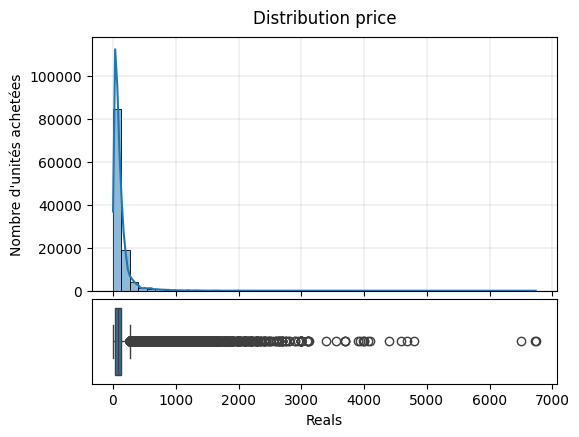

In [71]:
# Histogramme et boxplot variable `price`
plot_distribution(df_order_items, 'price', 'Reals', 'Nombre d\'unités achetées')

In [72]:
# Principales mesures statistiques
df_order_items['price'].to_frame().describe()

,price
count,112279.000000
mean,120.607707
std,183.644889
min,0.850000
25%,39.900000
50%,74.990000
75%,134.900000
max,6735.000000


> Sur la période 2016 - 2018, 1 euro valait entre 3.2326 réals au minimum et 4.9181 au maximum    
> *(Source : [exchange_rates.org](https://www.exchange-rates.org/fr/historique/eur-brl-2018))*
* Prix du produit le plus cher : 6 735 / 3.2326 = 2 083 €, rien d'anormal

* Distribution variable `freight_value`

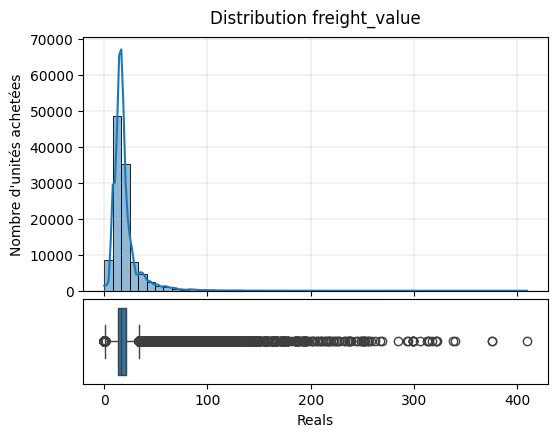

In [73]:
# Histogramme et boxplot variable `freight_value`
plot_distribution(df_order_items, 'freight_value', 'Reals', 'Nombre d\'unités achetées')

In [74]:
# Principales mesures statistiques
df_order_items['freight_value'].to_frame().describe()

,freight_value
count,112279.000000
mean,19.990299
std,15.809851
min,0.000000
25%,13.080000
50%,16.260000
75%,21.150000
max,409.680000


* Logiquement les distributions se ressemblent, plus un produit est cher, plus élevés sont ses frais de livraison
* Certaines valeurs sont à 0, rien d'anormal (livraisons gratuites)

### 3.4.3 Calcul de la feature `Montant`

In [75]:
# 'total_price' et 'total_freight' pour chaque 'id_order'
df_amounts_by_orders = df_order_items.groupby('order_id').agg(
    total_price = ('price', 'sum'),
    total_freight = ('freight_value', 'sum')
).reset_index()

# Ajout montant total de chaque commande
df_amounts_by_orders['total_order'] = df_amounts_by_orders['total_price'] + df_amounts_by_orders['total_freight']

In [76]:
# Ajout du 'customer_id' et suppression variables 'total_price' et 'total_freight'
df_amounts_by_orders = pd.merge(df_orders[['order_id', 'customer_id']], df_amounts_by_orders[['total_order', 'order_id']], on='order_id', how='inner')

In [77]:
# Ajout du 'customer_unique_id'
df_amounts_by_orders = pd.merge(df_customers[['customer_id', 'customer_unique_id']], df_amounts_by_orders, on='customer_id', how='right')

In [78]:
# Montant total par client
df_amount_by_customer = df_amounts_by_orders.groupby('customer_unique_id')['total_order'].sum().reset_index().rename(columns={'total_order': 'Montant'})
display(df_amount_by_customer)

,customer_unique_id,Montant
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89
...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42
95117,fffea47cd6d3cc0a88bd621562a9d061,84.58
95118,ffff371b4d645b6ecea244b27531430a,112.46
95119,ffff5962728ec6157033ef9805bacc48,133.69


## 3.5 Création du dataframe `df_features`

### 3.5.1 Feature `Récence`

* Préparation des éléments

In [79]:
# Merge des features 'customer_unique_id' et 'order_purchase_timestamp' 
df_purchase_timestamp = pd.merge(df_orders[['customer_id', 'order_purchase_timestamp']], df_customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

In [80]:
# Récupération de la date de dernier achat de chaque 'customer_unique_id'
last_purchase_dates = df_purchase_timestamp.groupby(['customer_unique_id']).agg(
    last_purchase_timestamp = ('order_purchase_timestamp', 'max')
).reset_index()

In [81]:
# Conversion de la date de référence au format datetime "YYYY-MM-DD 00:00:00"
last_order_date = pd.to_datetime('2018-08-31')

# Conversion de la date de dernier achat au format datetime "YYYY-MM-DD 00:00:00"
last_purchase_dates['last_purchase_timestamp'] = last_purchase_dates['last_purchase_timestamp'].dt.normalize()

* Calcul de la feature

In [82]:
# Calcul de la feature 'Récence'
last_purchase_dates['Récence'] = (last_order_date - last_purchase_dates['last_purchase_timestamp']).dt.days

* Création du dataframe `df_features`

In [83]:
# Création du dataframe 'df_features' avec feature 'Récence'
df_features = last_purchase_dates[['customer_unique_id', 'Récence']]

In [84]:
# Affichage de quelques exemples
display(df_features.sort_values('Récence'))

,customer_unique_id,Récence
67309,b4dcade04bc548b7e3b0243c801f8c26,2
34469,5c58de6fb80e93396e2f35642666b693,2
45461,7a22d14aa3c3599238509ddca4b93b01,2
92188,f80013faf776e37bcea7634d59c2181e,2
68102,b701bebbdf478f5500348f03aff62121,2
...,...,...
36606,6222ef69df52b4ed71be551725551cc0,603
68680,b88b78a413e70182e18b032361b24f91,603
67990,b6b2c3c8fd76769b478618a3c2505009,603
80115,d753459418d268407f19b64be28e3c5a,603


### 3.5.2 Feature `Fréquence`

* Pour rappel, calcul de la feature `Fréquence` :
   * Un score de **0** sera attribué aux clients n'ayant effectué qu'**une commande**  
   * Un score de **1** sera attribué aux clents ayant passé **2 commandes ou plus**

* Calcul du nombre de commandes par clients

In [85]:
# Nombre de commandes par clients
df_number_of_orders_by_customer = df_customers.groupby('customer_unique_id')['customer_id'].count().reset_index()

 * Création de la feature dans 'df_features'

In [86]:
# Ajout du nombre de commandes
df_features = pd.merge(df_features, df_number_of_orders_by_customer, on='customer_unique_id', how='inner')

# Changement de nom à la colonne 'customer_id' qui contient le nombre de commandes passées
df_features.rename(columns={'customer_id': 'Fréquence'}, inplace=True)

* Calcul du score de Fréquence

In [87]:
# Masque de séléction des clients ayant passé une seule commande
only_one_order_mask = df_features['Fréquence'] == 1

In [88]:
# Attribution du score de Fréquence 0 aux clients ayant passé une seule commande
df_features.loc[only_one_order_mask, 'Fréquence'] = 0

# Attribution du score de Fréquence 1 aux autres clients
df_features.loc[~only_one_order_mask, 'Fréquence'] = 1

* Affichage de quelques exemples

In [89]:
df_features.sort_values('Fréquence')

,customer_unique_id,Récence,Fréquence
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0
62945,a926cfc9bc7b082335de50450f48eec9,129,0
62944,a926aae38267e7f54e67de9b5775d0a5,29,0
62943,a92605ec492805540520d3a73aaeeb6e,259,0
62942,a925c3e5df82fdc6082f1383d2834998,138,0
...,...,...,...
38863,68497ce04e9b12cb402671a29acdf6a2,113,1
10723,1c98969880c8c7c522bc4677dfce9384,162,1
2657,071fb07419a29c8ba143831082e0320a,233,1
55059,944779ed5e0464b49fbb2108382b0ddf,28,1


### 3.5.3 Feature `Montant`

* Ajout de la feature `Montant` au dataframe `df_features`

In [90]:
df_features = pd.merge(df_features, df_amount_by_customer, on='customer_unique_id', how='left')

* Affichage de quelques exemples

In [91]:
df_features.sort_values('Montant')

,customer_unique_id,Récence,Fréquence,Montant
18455,317cfc692e3f86c45c95697c61c853a6,6,0,9.59
70338,bd06ce0e06ad77a7f681f1a4960a3cc6,352,0,10.07
66708,b33336f46234b24a613ad9064d13106d,71,0,10.89
15083,2878e5b88167faab17d4fb83a986d38b,306,0,11.63
41477,6f5b9d1cdccc4d28f0483a612edecacf,363,0,11.63
...,...,...,...,...
25928,459bef486812aa25204be022145caa62,37,0,6922.21
81977,dc4802a71eae9be1dd28f5d788ceb526,565,0,6929.31
44005,763c8b1c9c68a0229c42c9fc6f662b93,47,0,7274.88
81136,da122df9eeddfedc1dc1f5349a1a690c,517,1,7571.63


## 3.6 Normalisation

Les alogorithmes de clustering basés sur la distance, comme KMeans, attendent que la contribution de chaque variable soit équilibrée, sans être biaisée par des unités de mesure ou des écehelles différentes  
* Une **normalisation Min-Max** via **MinMaxScaler**permettra de s'assurer que toutes les variables aient des valeurs comprises entre 0 et 1  

Avant de procéder à la normalisation, une rapide analyse univariée de chaque feature sera réalisée

### 3.6.1 Informations générales sur le dataset

* Caratéristiques statistiques de base

In [92]:
display(get_dataframe_infos(df_features))
display(df_features.describe())

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,customer_unique_id,object,95121,0,0,0.0 %
1,Récence,int64,602,94519,0,0.0 %
2,Fréquence,int64,2,95119,0,0.0 %
3,Montant,float64,31604,63517,0,0.0 %


,Récence,Fréquence,Montant
count,95121.000000,95121.000000,95121.000000
mean,239.076765,0.030487,165.959184
std,151.274715,0.171925,228.362631
min,2.000000,0.000000,9.590000
25%,116.000000,0.000000,63.100000
50%,221.000000,0.000000,107.900000
75%,348.000000,0.000000,183.040000
max,603.000000,1.000000,13664.080000


* Comme attendu, la variable `customer_unique_id` identifie les clients de manière unique, il n'y a pas de doublons  
* Aucunes valeurs manquantes  
* Les minimum et maximum sont cohérents
* Les échelles de valeurs sont très différentes, les phases de standardisation et normalisation seront nécessaires

### 3.6.2 Feature `Récence`

* Distribution

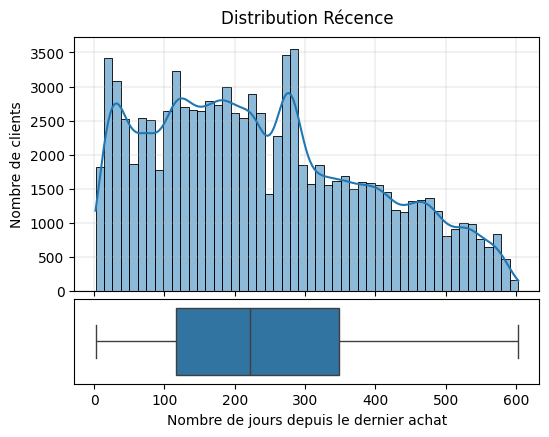

In [93]:
# Histogramme et boxplot
plot_distribution(df_features, 'Récence', 'Nombre de jours depuis le dernier achat', 'Nombre de clients')

* Normalisation Min-Max

In [94]:
# Normalisation Min-Max
minmax_scaler = MinMaxScaler()
df_features['Récence_minmax'] = minmax_scaler.fit_transform(df_features[['Récence']])

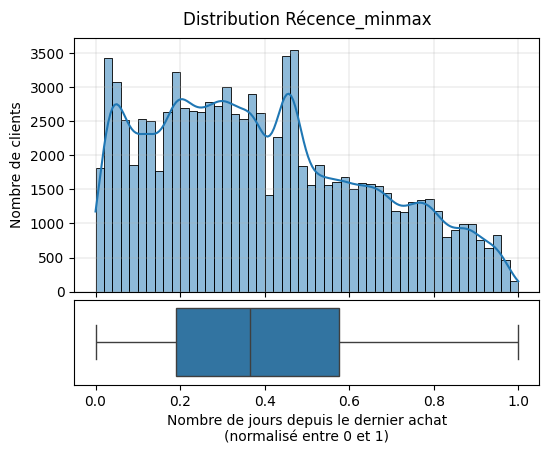

In [95]:
# Histogramme et boxplot
plot_distribution(df_features, 'Récence_minmax', 'Nombre de jours depuis le dernier achat\n(normalisé entre 0 et 1)', 'Nombre de clients')

* Logiquement l'apparence de la distribution ne change pas  
* Les valeurs sont bien comprises entre 0 et 1

### 3.6.3 Feature `Fréquence`

* Distribution

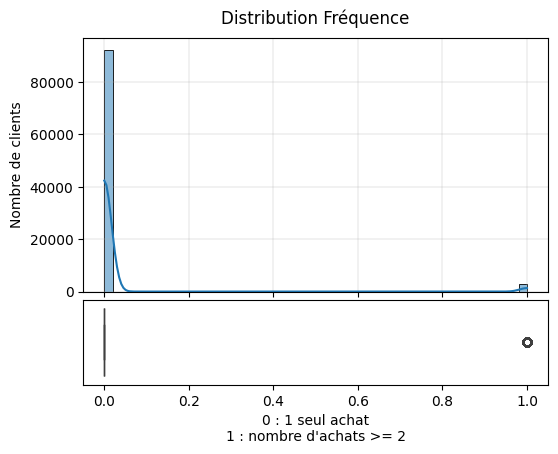

In [96]:
# Histogramme et boxplot
plot_distribution(df_features, 'Fréquence', f'0 : 1 seul achat\n1 : nombre d\'achats >= 2', 'Nombre de clients')

* La forme de la distribution est cohérente avec le fait que cette feature ne peut prendre que 2 valeurs :  
   * **0** pour les clients ayant effectué un seul achat (environ **97 %** d'entre eux)  
   * **1** pour ceux ayant effectué 2 achats ou plus (un peu plus de **3 %**)
* Une normalisation MinMax n'apporterait rien

### 3.6.4 Feature `Montant`

* Distribution

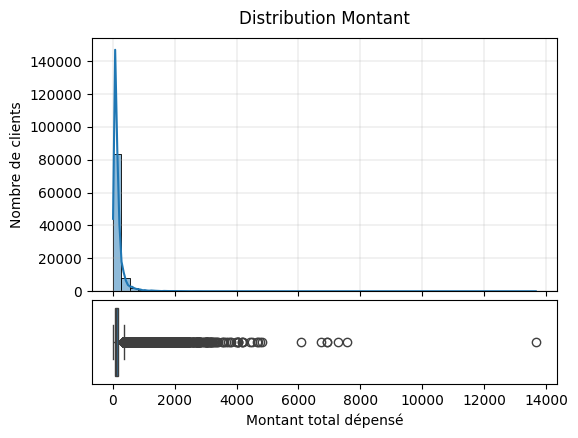

In [97]:
# Histogramme et boxplot
plot_distribution(df_features, 'Montant', 'Montant total dépensé', 'Nombre de clients')

* Beaucoup d'achats avec des montants faibles, peu avec des montants plus importants
* L'échelle est quelque peu biaisée compte-tenu de l'unité utilisée (Réals)

* Normalisation Min-Max

In [98]:
# Normalisation Min-Max
minmax_scaler = MinMaxScaler()
df_features['Montant_minmax'] = minmax_scaler.fit_transform(df_features[['Montant']])

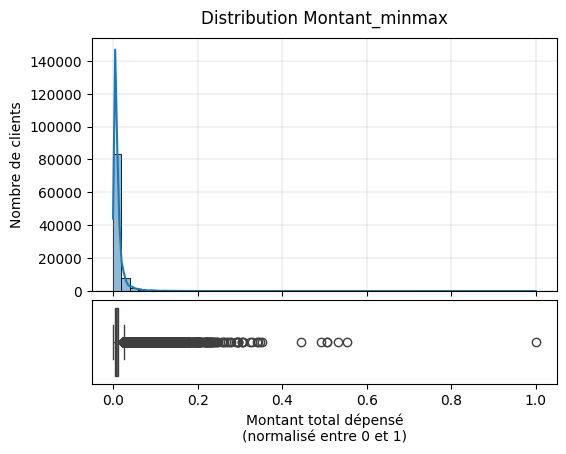

In [99]:
# Histogramme et boxplot
plot_distribution(df_features, 'Montant_minmax', 'Montant total dépensé\n(normalisé entre 0 et 1)', 'Nombre de clients')

* Logiquement l'apparence de la distribution ne change pas  
* Les valeurs sont bien comprises entre 0 et 1

# 4 Finalisation du dataset

## 4.1 Aperçu

In [100]:
# Affichage des premières et dernières lignes
display(df_features)

,customer_unique_id,Récence,Fréquence,Montant,Récence_minmax,Montant_minmax
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0.009690
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0.001289
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0.005612
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0.002492
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0.013717
...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0.150707
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0.005492
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0.007534
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0.009089


## 4.2 Mise en forme du dataset

Pour plus de clarté lors de la phase d'élaboration des modèles de clustering :   
* Changement de nom feature `customer_unique_id` -> `Id client`  
* Conservation des 3 features dans leur version d'origine avec les noms : `Récence_orig`, `Fréquence_orig`, `Montant_orig`
* Changement de noms des features normalisées : `Récence`, `Fréquence`, `Montant`

In [101]:
# Changement de nom feature `customer_unique_id`
df_features.rename(columns={'customer_unique_id': 'Id client'}, inplace=True)

In [102]:
# Features RFM en version d'origine
df_features.rename(columns={'Récence': 'Récence_orig',
                            'Fréquence': 'Fréquence_orig',
                            'Montant': 'Montant_orig'},
                  inplace=True)

In [103]:
# Features RFM pour modèles
df_features.rename(columns={'Récence_minmax': 'Récence',
                            'Montant_minmax': 'Montant'},
                   inplace=True)
df_features['Fréquence'] = df_features['Fréquence_orig']

In [104]:
# Changement d'ordre des features
df_features = df_features[['Id client', 'Récence_orig', 'Fréquence_orig', 'Montant_orig', 'Récence', 'Fréquence', 'Montant']]

* Affichage du dataset mis en forme

In [105]:
# Affichage des premières et dernières lignes
display(df_features)

,Id client,Récence_orig,Fréquence_orig,Montant_orig,Récence,Fréquence,Montant
0,0000366f3b9a7992bf8c76cfdf3221e2,113,0,141.90,0.184692,0,0.009690
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,0,27.19,0.189684,0,0.001289
2,0000f46a3911fa3c0805444483337064,539,0,86.22,0.893511,0,0.005612
3,0000f6ccb0745a6a4b88665a16c9f078,323,0,43.62,0.534110,0,0.002492
4,0004aac84e0df4da2b147fca70cf8255,290,0,196.89,0.479201,0,0.013717
...,...,...,...,...,...,...,...
95116,fffcf5a5ff07b0908bd4e2dbc735a684,449,0,2067.42,0.743760,0,0.150707
95117,fffea47cd6d3cc0a88bd621562a9d061,264,0,84.58,0.435940,0,0.005492
95118,ffff371b4d645b6ecea244b27531430a,570,0,112.46,0.945092,0,0.007534
95119,ffff5962728ec6157033ef9805bacc48,121,0,133.69,0.198003,0,0.009089


## 4.3 Enregistrement du dataset

In [106]:
# Enregistrement 'df_features.csv' dans le répertoire courant
df_features.to_csv('df_features.csv', index=False)